# Project 3

Florian Michael-Schwarzinger and Dieter Brehm - Project 3 - Fall 2018


In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question

Explanation goes here

## Model

Explanation goes here

In [20]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [54]:
param = Params(r_earth = 6.3781e6 * m,
                epo = 190756 * m,
                r_0 = r_earth + epo,
                x0 = r_0,
                y0 = 0 * m,
                vx0 = 0 * m / s,
                vy0 = -7792 * m / s,
                G=6.674e-11 * N / kg**2 * m**2,
                m_earth=5.972e24 * kg,
                m_apollo=13284 * kg,
                t_0=0 * s,
                t_end=100000 * s)

,values
r_earth,6378100.0 meter
epo,190756 meter
r_0,6.56886e+06
x0,6.56886e+06
y0,0 meter
vx0,0.0 meter / second
vy0,-7792.0 meter / second
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_earth,5.972e+24 kilogram
m_apollo,13284 kilogram


In [55]:
def make_system(params):
    """Make a system object.
    
    params: Params object with r_earth, epo, r_0, x0, y0,
                vx0, vy0, G, m_earth, m_apollo, t_0, t_end
               
    returns: System object
    """
    
    unpack(params)
    
    init = State(x = x0,
                 y = y0,
                 vx = vx0,
                 vy = vy0)
                 
    sys = System(init=init,
                 G=G,
                 m_earth=m_earth,
                 m_apollo=m_apollo,
                 t_0=t_0,
                 t_end=t_end)
    return sys

system = make_system(param)

,values
init,x 6.56886e+06 y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_earth,5.972e+24 kilogram
m_apollo,13284 kilogram
t_0,0 second
t_end,100000 second


In [56]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    pos = Vector(x, y)
    
    Fx, Fy = pol2cart(pos.angle, G * m_earth * m_apollo / pos.mag **2) 
    
    force = Vector(Fx, Fy)
    
    return force

In [57]:
# Test our gravitation function to see if it seem reasonable.
universal_gravitation(system[0], system)

<Quantity([122703.05769108      0.        ], 'newton')>

In [58]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)

    acc_grav = universal_gravitation(state, system) / m2
    
    #print("runnin' code!, current position is x:", x, " y:", y)
    
    dydt = Vector(vx, vy)
    dvdt = -acc_grav
    
    return dydt.x, dydt.y, dvdt.x, dvdt.y

In [59]:
# Always test the slope function!
slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-7792.0, 'meter / second')>,
 <Quantity(-9.236905878581915, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [69]:
# make an event function to stop the simulation when the
# apollo module crashes into the earth

def event_func(state, t, system):
    """Error function used to stop the simulation when the
        spacecraft crashes into the earth.
    
    state object: 
    current timestamp: 
    system object:
               
    returns: num that is 0 when crash occurs
    """
    x, y, vx, vy = state
    pos = Vector(x, y)
    return pos.mag - r_earth

In [61]:
event_func(init, 0, system)

<Quantity(190756.0, 'meter')>

In [62]:
# Finally we can run the simulation
system = make_system(param)
results, details = run_ode_solver(system, slope_func, events=event_func)

In [63]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(3467.7598572684, 'second')>

In [64]:
# ... expressed in units we understand

t_final.to(UNITS.hour)

<Quantity(0.963266627019, 'hour')>

In [70]:
# Before plotting, we run the simulation again with `t_eval`
ts = linspace(t_0, t_final, 1000)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

type(results)

modsim.TimeFrame

In [71]:
#wrap this plotting into a function
def plot_orbit(simulation_results, earth, potential_path):
    """Pretty plot the results of the simulation.
    
    simulation_results: Timeframe object that is the result of the simulation
    earth: bool, whether or not you want to draw the earth in the plot
    potential_path: bool, whether or not you want to keep running the simulation
        in a second stage after the ship crashes into the earth to see what would
        have happened
               
    returns: tuple of two matplotlib figure objects
    """
    x = simulation_results.x / 1000
    y = simulation_results.y / 1000;
    
    # plot x and y versus time of the simulation
    # to show movement trends
    fig1 = plt.figure(figsize=(8, 8), dpi=180)
    ax1 = fig1.add_subplot(211)
    ax1.plot(results.index / 60 / 60, x, label='x')
    ax1.plot(results.index / 60 / 60, y, label='y')
    ax1.set_ylabel("Position (km)")
    ax1.set_xlabel("Time (hours)")
    ax1.legend(["x", "y"])
    ax1.set_title("Distance of apollo module from center of earth");
    
    # plot x vs. y to show movement of the spacecraft
    fig2 = plt.figure(figsize=(7, 16), dpi=180)
    ax1 = fig2.add_subplot(211)
    ax1.plot(x, y, "r")
    ax1.set_ylabel("Y Position (km)")
    ax1.set_xlabel("X Position (km)")
    ax1.set_title("X and Y position of Apollo 11")
    
    # add a circle to represent the earth
    # the plot function didn't like using r_earth
    if earth == True:
        circle1 = plt.Circle((0, 0), radius=6.3781e6 / 1000, color='b')
        ax1.add_artist(circle1)
    
    return fig1, fig2

In [72]:
def run_simulation():
    """Wrapper to run the simulation.
               
    returns: results in a Timeframe object
    """
        
    r_earth = 6.3781e6
    epo = 190756

    r_0 = (r_earth + epo)

    init = State(x = r_0 * m,
                 y = 0 * m,
                 vx = 0 * m / s,
                 vy = 7792 * m / s, )
    
    system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=5.972e24 * kg,
                m2=292865 * kg,
                t_0=0 * s,
                t_end=100000 * s)
    
    results, details = run_ode_solver(system, slope_func, events=event_func)
    t_final = get_last_label(results) * s
    t_final.to(UNITS.hour)
    
    ts = linspace(t_0, t_final, 1000)
    results, details = run_ode_solver(system, 
                                      slope_func,
                                      events=event_func,
                                      t_eval=ts)
    
    return results

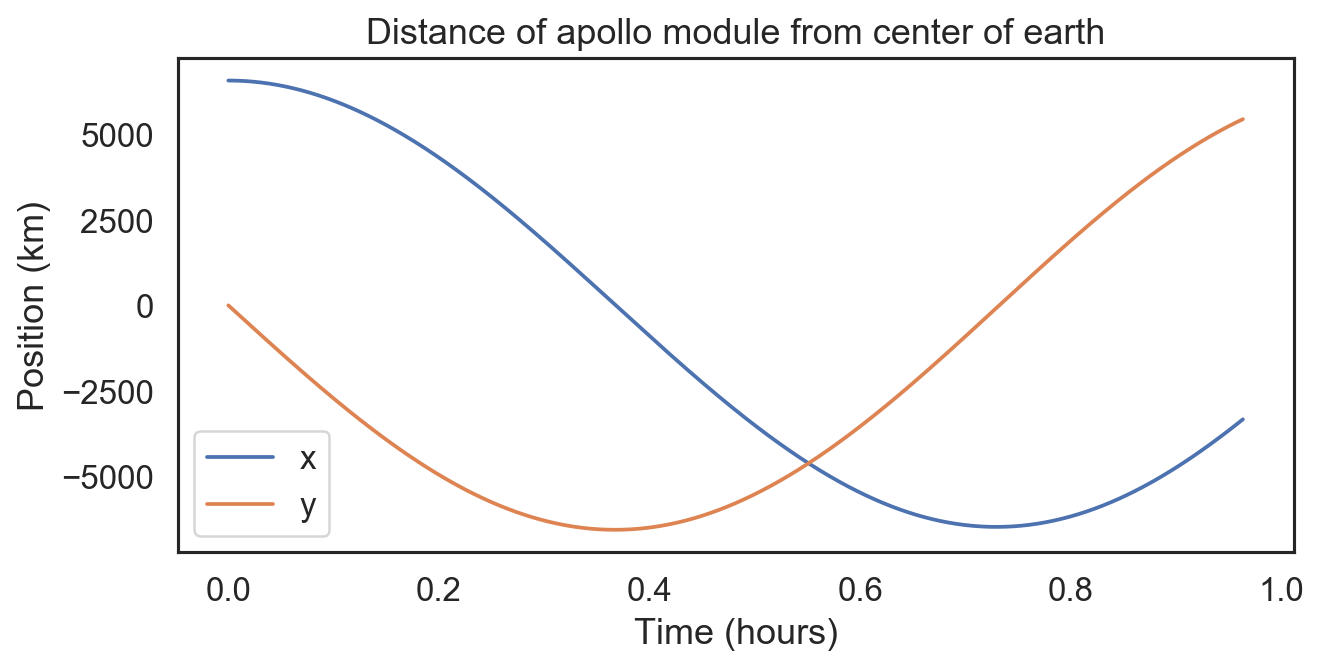

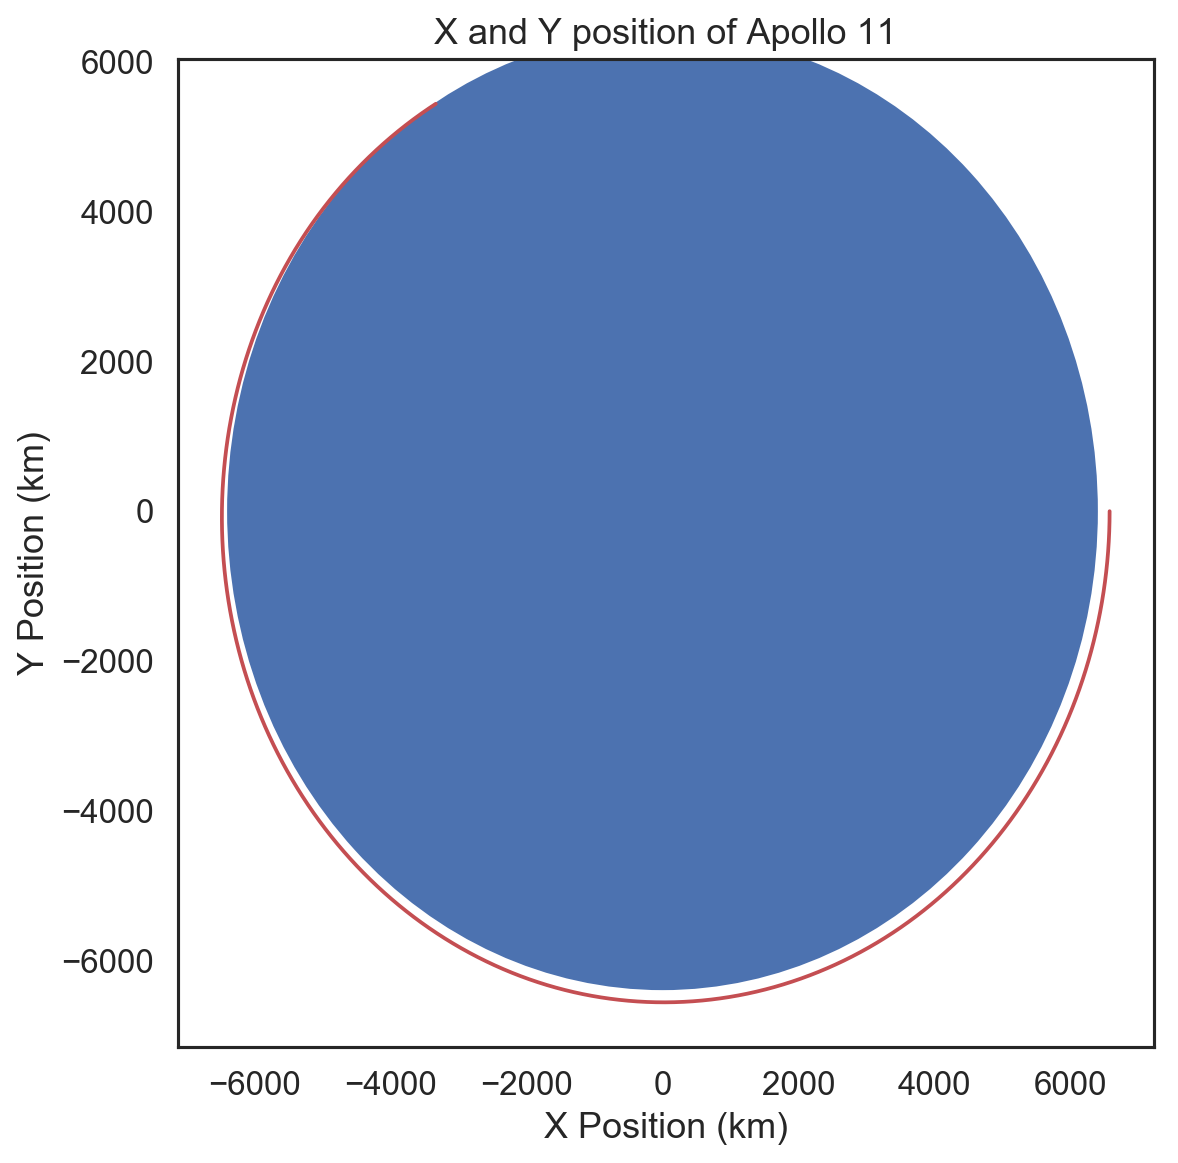

In [68]:
#results_blah = run_simulation()
plot1, plot2 = plot_orbit(results, True, True)

## Optimizer - Velocity
Here we will try to optimize the craft's velocity in order to get as clean and sustainable EPO as possible. I.E an orbit which keeps the spacecraft as close to the ideal EPO orbit as long as possible.


In [ ]:
# params object to set up the system for optimization
params = Params

## Validation

Use the mission flight report as validation. May just be a plot to diagram comparison or a quote from the report about flight statistics.